In [1]:
%load_ext autoreload
%autoreload 2

import sys
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

sys.path.append('../')

from src.preprocessing import set_seed, get_shuffle, get_transforms
from src.dataset import VINDataset
from settings.config import Config

import warnings
warnings.filterwarnings('ignore')

In [39]:
set_seed(Config.seed)

datasets = {name: VINDataset(name) for name in ['train', 'test']}
dataloaders = {name: DataLoader(datasets[name], batch_size=Config.batch_size, 
                                shuffle=get_shuffle(name), num_workers=Config.num_workers) 
               for name in ['train', 'test']}

In [19]:
from src.model import get_model, train

model = get_model()
model.load_state_dict(torch.load('../models/efficientnetv5.pt'))
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.learning_rate)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90, verbose=True)
callbackers = train(model, optimizer, criterion, dataloaders['train'], dataloaders['test'], lr_scheduler=lr_scheduler, model_name='efficientnetv6')

Adjusting learning rate of group 0 to 7.0000e-05.


KeyboardInterrupt: 

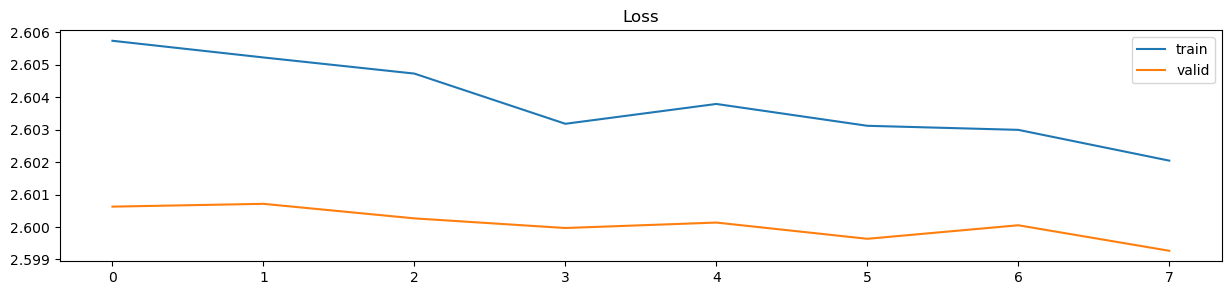

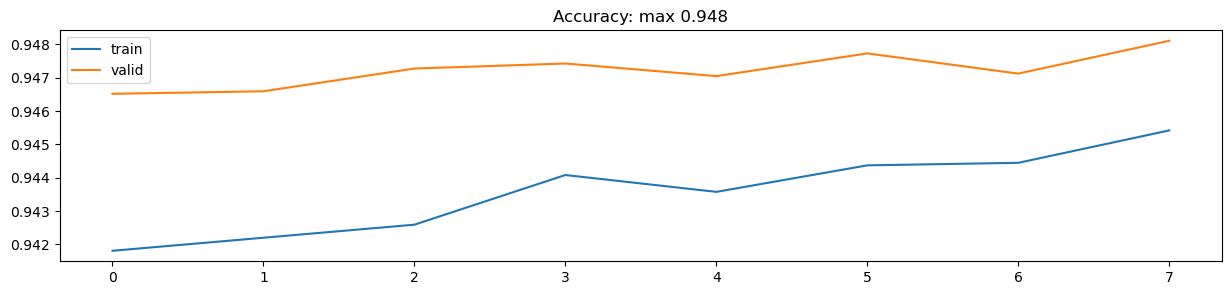

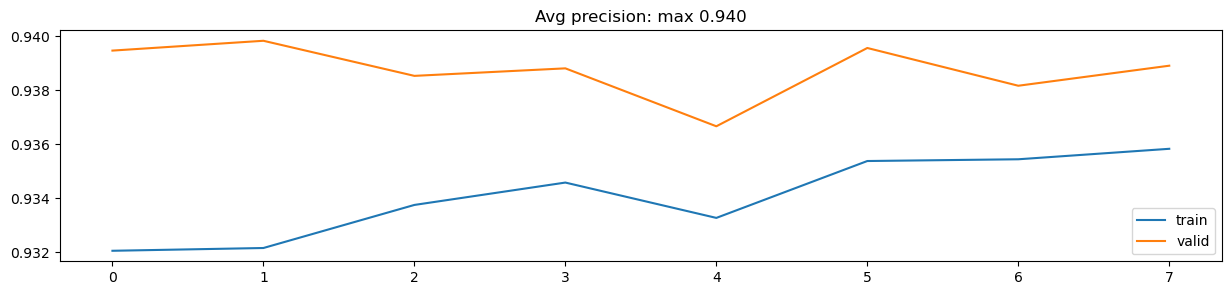

<Axes: >

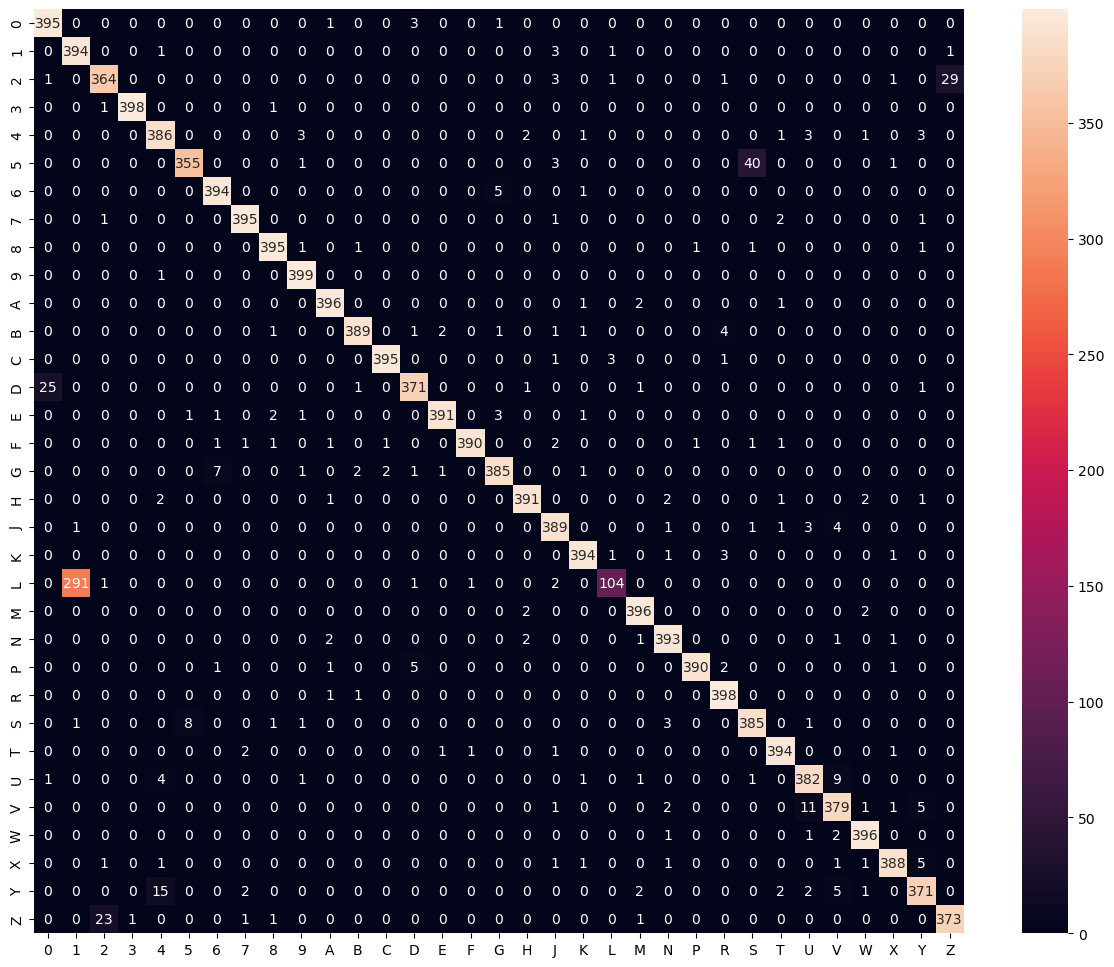

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(15,3))
plt.plot(callbackers['train_loss'], label='train')
plt.plot(callbackers['valid_loss'], label='valid')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(callbackers['train_accuracy'], label='train')
plt.plot(callbackers['valid_accuracy'], label='valid')
plt.legend()
plt.title(f'Accuracy: max {max(callbackers["valid_accuracy"]):.3f}')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(callbackers['train_avg_precision'], label='train')
plt.plot(callbackers['valid_avg_precision'], label='valid')
plt.legend()
plt.title(f'Avg precision: max {max(callbackers["valid_avg_precision"]):.3f}')
plt.show()


plt.figure(figsize=(15,12))
cf = confusion_matrix(callbackers['valid_targets'], callbackers['valid_predictions'])
t = datasets['train'].mapping['char'].values
cf = pd.DataFrame(cf, columns=t, index=t)
sns.heatmap(cf, annot=True, fmt='.0f', )

In [5]:
print(classification_report(callbackers['valid_targets'], callbackers['valid_predictions']))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       400
           1       0.57      0.98      0.72       400
           2       0.94      0.89      0.92       400
           3       0.99      1.00      1.00       400
           4       0.95      0.95      0.95       400
           5       0.95      0.92      0.93       400
           6       0.97      0.99      0.98       400
           7       0.98      0.99      0.99       400
           8       0.98      0.98      0.98       400
           9       0.98      0.99      0.99       400
          10       0.99      0.99      0.99       400
          11       0.98      0.97      0.98       400
          12       0.99      0.98      0.98       400
          13       0.93      0.96      0.95       400
          14       0.99      0.98      0.99       400
          15       0.99      0.97      0.98       400
          16       0.98      0.96      0.97       400
          17       0.98    

In [6]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import numpy as np

m = efficientnet_b3(weights=None)
m.features[0][0] = torch.nn.Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
m.classifier[1] = torch.nn.Linear(in_features=1536, out_features=Config.num_classes, bias=True)
m.load_state_dict(torch.load('../models/efficientnetv4.pt'))
m.eval()

predictions = []
targets = []
images = []
for imgs, labels in datasets['test']:
    imgs = torch.unsqueeze(imgs, 0)
    preds = torch.argmax(m(imgs), axis=1)
    #if labels.item() == 20 or labels.item() == 1 or preds[0] == 20 or preds[0] == 1:
    predictions.extend(preds)
    targets.append(labels.item())
    images.append(imgs.numpy())
predictions = [el.item() for el in predictions]
targets = [el for el in targets]
images = np.concatenate(images, axis=0)
images = images[:, 0, : ,:]

In [29]:
1e-4 * 0.84

8.4e-05

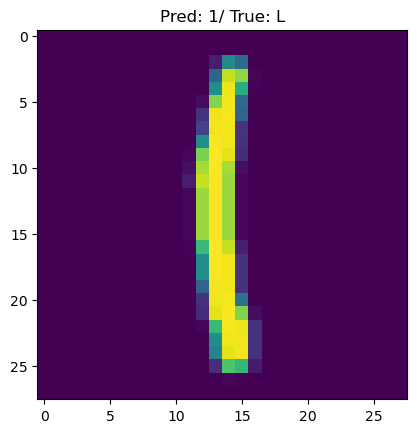

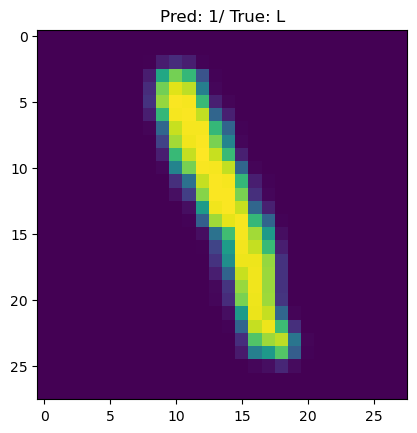

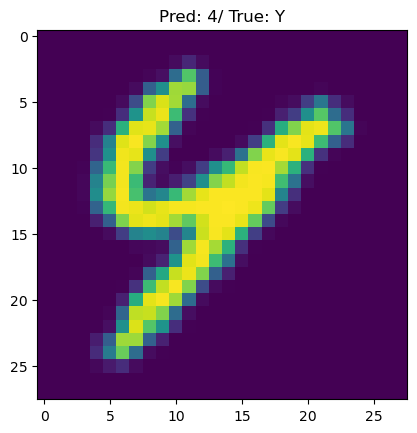

In [16]:
import numpy as np

mapping = datasets['train'].mapping
errs = np.argwhere(np.array(predictions) != np.array(targets)).flatten()
idx = np.random.permutation(range(errs.shape[0]))
for i in errs[idx][:6]:
    plt.imshow(images[i].T)
    plt.title(f'Pred: {mapping["char"][predictions[i]]}/ True: {mapping["char"][targets[i]]}')
    plt.show()

In [35]:
400 * 0.01 * 33

132.0

In [40]:
np.random.uniform(0,1,100)

88

In [65]:
mapping.iloc[3]['ASCII']

51

In [99]:
3/ 28

0.10714285714285714

In [148]:
400 * 0.01 * 33

132.0

In [41]:

mapping = datasets['train'].mapping

In [42]:
import cv2 as cv
for i, el in enumerate(datasets['test']):
    if np.random.uniform() < 0.01:
        im = (el[0][0].T.numpy()).astype(int)
        l = el[1].item()
        im = (im > 70).astype(int)*255
        im[:, :1] = 255
        im[:, -1:] = 255
        im[:1, :] = 255
        im[-1:, :] = 255
        
        
        if np.random.uniform() < 0.7:
            cv.imwrite(f'../test_folder/{i}_{mapping.iloc[l]["ASCII"]}.jpg', im)
        else:
            cv.imwrite(f'../test_folder/{i}_{mapping.iloc[l]["ASCII"]}.png', im)